In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks

In [194]:
# definerer parametre

k_Nin = 5.4 # min^{-1}
k_lin = 0.018 # min^{-1} 
k_t = 1.03 # mu * M^{-1} * min^{-1}
k_tl = 0.24 # min^{-1}
K_I = 0.035 # mu * M
K_N = 0.029 # mu * M
gamma_m = 0.017 # min^{-1}
alpha = 1.05 # mu * M^{-1} * min^{-1}
N_tot = 1 # mu * M
k_a = 0.24 # min^{-1}
k_i = 0.18 # min^{-1}
k_p = 0.036 # min^{-1}
k_A20 = 0.0018 # mu * M
IKK_tot = 2.0 # mu * M
A20 = 0.0026 # mu * M

In [310]:
# definerer tid
t_samlet = (0, 50000)

# definerer startparametere
N_n0, I_m0, I0, IKK_a0, IKK_i0, TNF_k = 1, 1, 1, 1, 1, 0.5
y0 = [N_n0, I_m0, I0, IKK_a0, IKK_i0, TNF_k]

In [311]:
# definerer ligningssystemet
def N_n_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dN_ndt = k_Nin * (N_tot - N_n)*K_I/(K_I+I)-k_lin*I*N_n/(K_N + N_n)
    return dN_ndt

def I_m_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dI_mdt = k_t * N_n**2 - gamma_m * I_m
    return dI_mdt

def I_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIdt = k_tl*I_m - alpha * IKK_a * (N_tot-N_n)*I/(K_I + I)
    return dIdt

def IKK_a_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIKK_adt = k_a * TNF * (IKK_tot - IKK_a - IKK_i) - k_i * IKK_a
    return dIKK_adt

def IKK_i_change(t, N_n, I_m, I, IKK_a, IKK_i, TNF):
    dIKK_idt = k_i * IKK_a - k_p * IKK_i * k_A20 / (k_A20 + A20 * TNF)
    return dIKK_idt

def samlet_system_nfkb(t, y):
    dydt = np.zeros_like(y)
    dydt[0] = N_n_change(t, *y)
    dydt[1] = I_m_change(t, *y)
    dydt[2] = I_change(t, *y)
    dydt[3] = IKK_a_change(t, *y)
    dydt[4] = IKK_i_change(t, *y)
    return dydt

In [312]:
# udfører simulation
simulation = solve_ivp(samlet_system_nfkb, t_samlet, y0, method='RK45')

t_trans, N_n_trans, I_m_trans, I_trans, IKK_a_trans, IKK_i_trans = simulation["t"], simulation["y"][0], simulation["y"][1], simulation["y"][2], simulation["y"][3], simulation["y"][4]



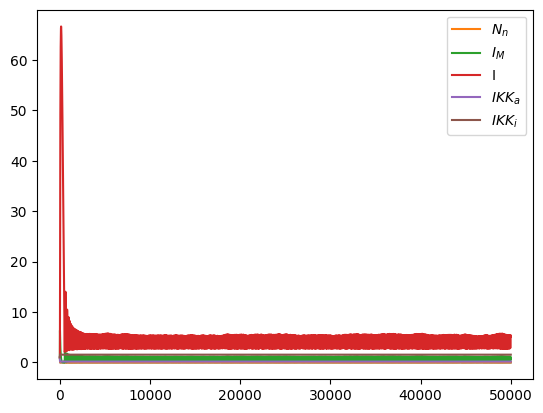

In [313]:
# plotter første simulation
plt.plot(simulation["t"], simulation["y"][0])
plt.plot(t_trans, N_n_trans, label='$N_n$')
plt.plot(t_trans, I_m_trans, label='$I_M$')
plt.plot(t_trans, I_trans, label='I')
plt.plot(t_trans, IKK_a_trans, label='$IKK_a$')
plt.plot(t_trans, IKK_i_trans, label='$IKK_i$')
plt.legend();

In [314]:
# Compute stats for p53 transient to find period and amplitude for nutlin simulation
def compute_int_oscillator(t, y): #mean, amplitude, period
    y_peaks = find_peaks(y)[0]
    y_troughs = find_peaks(-y)[0]

    # keep the last 10 peaks
    stable_peaks = None
    stable_troughs = None
    if len(y_peaks) > 12 and len(y_peaks) > len(y_troughs):
        stable_peaks = y_peaks[-12:-1]
        stable_troughs = y_troughs[-11:-1]
    else:
        stable_peaks = y_peaks[-11:-1]
        stable_troughs = y_troughs[-12:-2]
        
    period = np.mean((np.diff(t[stable_peaks]) + np.diff(t[stable_troughs]))/2)
    
    amplitude = np.mean((y[stable_peaks] - y[stable_troughs])/2)

    mean_value = np.mean(np.concatenate((y[stable_peaks] - amplitude, y[stable_troughs] + amplitude)))

    return period, amplitude, mean_value, stable_peaks, stable_troughs

In [315]:
# udregner beskrivelse af intern oscillator
T_int, A_int, mean_int, stable_peaks_int, stable_troughs_int = compute_int_oscillator(t_trans, N_n_trans)

# definerer konstant som holder TNF>0
k=0.5

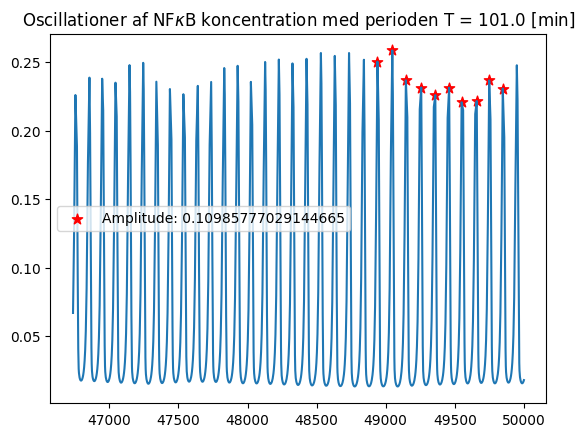

In [316]:
# plotter valgte peaks
plt.scatter(t_trans[stable_peaks_int], N_n_trans[stable_peaks_int], s=60, c="red", marker='*', label=f"Amplitude: {A_int}")
plt.plot(t_trans[-1000:], N_n_trans[-1000:])
plt.legend()
plt.title(f"Oscillationer af NF$\kappa$B koncentration med perioden T = {T_int:.4} [min]");

In [324]:
# definerer funktion, som oscillerer TNF (A_eks<k)
def sim_TNF_oscillation(oscillationer, T_int, OOmega, N_n0, I_m0, I0, IKK_a0, IKK_i0, TNF0):
    # This is correct, and it is working! Remember to count in period values, not frequency! If you count in frequency, you are counting the reciprocal.
    T_ext = OOmega * T_int
    omega = T_int / T_ext

    history = {"t":[] ,"N_n": [], "I_m": [], "I": [], "IKK_a":[], "IKK_i":[], "TNF":[]}

    for i in range(oscillationer*2):
        if i == 0:
            state = N_n0, I_m0, I0, IKK_a0, IKK_i0, TNF0
            sys = solve_ivp(samlet_system_nfkb, (0, T_ext/2), state, method='RK45', max_step=5, dense_output=True)
            t, N_n, I_m, I, IKK_a, IKK_i = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
            history["t"].extend(t)
            history["N_n"].extend(N_n)
            history["I_m"].extend(I_m)
            history["I"].extend(I)
            history["IKK_a"].extend(IKK_a)
            history["IKK_i"].extend(IKK_i)
            history["TNF"].extend(TNF0)
        
        TNF_i = - history["TNF"][-1] + 2*k
        state = history["N_n"][-1], history["I_m"][-1], history["I"][-1], history["IKK_a"][-1], history["IKK_i"][-1], 
        sys = solve_ivp(samlet_system_nfkb, (0, T_ext/2), state, method='RK45', max_step=5, dense_output=True)
        t, N_n, I_m, I, IKK_a, IKK_i = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
        history["t"].extend(t + history["t"][-1])
        history["N_n"].extend(N_n)
        history["I_m"].extend(I_m)
        history["I"].extend(I)
        history["IKK_a"].extend(IKK_a)
        history["IKK_i"].extend(IKK_i)
        history["TNF"].extend(TNF_i)
        
    return history, omega, T_ext

In [325]:
omega = 1
an_osc = 100
A = 0.2
TNF0 = A + k
p0 = [N_n0, I_m0, I0, IKK_a0, IKK_i0, TNF0]

In [326]:
N_n, I_m, I, IKK_a, ome, T_TNF = sim_TNF_oscillation(100, T_int, omega, *p0)

TypeError: 'float' object is not iterable